Загрузка модулей

In [1]:
from re import sub, compile
from pandas import DataFrame, Series
import numpy as np
from itertools import chain

from gensim import models, corpora
from gensim.utils import tokenize
from gensim.models import Word2Vec

from nltk import sent_tokenize, word_tokenize
from nltk.tokenize import wordpunct_tokenize, RegexpTokenizer
from nltk.corpus import stopwords

from pickle import load
from requests import get
from json import JSONDecodeError

from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from matplotlib.pylab import rcParams, savefig
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn 

from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer()

Хэндкрафтед-стоп-слова

In [2]:
stop = {'весь', 'всякий', 'тот', 'это', 'самое', 'каким', 'сама', 'никак', 'она', 'она', 'оно', 'какие', 'какого', 'которая', 'многое', 'чему', 'всему', 'раза', 'сразу', 'весь', 'раз', 'пор', 'например', 'вроде', 'которые', 'который', 'просто', 'очень', 'почему', 'вообще', 'ещё', 'типа', 'ради', 'всё', 'хотя', 'тебе', 'нужно', 'пока',\
'сделать', 'можешь', 'могу', 'могут', 'делать', 'будешь', 'быть', 'будут', 'смочь', 'поэтому', 'то', 'что', 'какой', 'как', 'кто'}

In [3]:
stop = stop.union(set(stopwords.words('russian')))

Загрузка регулярок

In [4]:
from re import sub, compile

def cut(data):
    r = compile(r'<.*?>|>>\d*|\(OP\)|&#(\d*);|&quot;|&gt;|(http|https):.*')
    return r.sub('', data).strip()

def pos_cut(s):
    s = sub(r"ADJF", "ADJ", s)
    s = sub(r"ADVB", "ADV", s)
    s = sub(r"INFN", "VERB", s)
    return s

def topic_cut(word):
    return sub('[^a-zA-Zа-яА-Я]', '', word)

def check_for_rus_lan(word):
    regex = compile('[А-Яа-я]+$')
    if regex.match(word):
        return True
    return False

def check_dirty(word):
    regexp = compile(r'уеб|хуё|ёб|пидо|иби|хуй|еба|бля|еби|хуе|хуи|пиз|срал|velf|оеб|ебаш|ебст|муд')
    if regexp.search(word):
          return True
    return False

Загрузка случайного пула постов и получение их длин

In [5]:
def load_threads(board='b'):
   # try:
    dvach_page = get('https://2ch.hk/' + board + '/catalog.json').json()
    return [i['num'] for i in dvach_page['threads']], board
   # except:
        # raise Exception('Could not find the specified board') 


def load_comments(threads, board='b'):
    comments = []
    for every_thread in threads:
        try:
            thread = get('https://2ch.hk/' + board + '/res/' + every_thread + '.json', timeout=5).json()
            [comments.append(sent_tokenize(cut(i['comment']))) for i in thread['threads'][0]['posts'] if
            len(cut(i['comment'])) > 2]
        except JSONDecodeError:
            pass
    return list(chain.from_iterable(comments))

posts = load_comments(*load_threads('b'))
posts_lengths = list(map(lambda i: len(i), posts))

Отрисовка графика длин постов

In [6]:
plt.figure(figsize=(20, 20))
seaborn.set_style('whitegrid')
plt.grid(False)
seaborn.distplot(posts_lengths, bins=100, rug=False, hist=False, color='black')

Очистка постов от стоп-слов

In [8]:
posts = [' '.join([word.lower() for word in word_tokenize(post) if word.lower() not in stop and not check_dirty(word.lower())]) for post in posts]

Получение числа употреблений каждого слова в наборе постов

In [9]:
NOT_IN_DICT = '<FakeDictionary>'
words_dict = {}

for text in posts:
    for word in tokenize(text):
        normal_word = morph.parse(word)[0].normal_form
        if len(word) > 2 and not check_dirty(word) and str(morph.parse(word)[0].methods_stack[0][0]) == NOT_IN_DICT:
            if normal_word not in words_dict:
                words_dict[normal_word] = 0
            else:
                words_dict[normal_word] += 1

Подсчёт частоты использования слов 

In [10]:
df = DataFrame.from_dict(words_dict, orient='index').reset_index()
df.columns = ['word', 'frequency']
df = df.sort_values(by=['frequency', 'word'], ascending=False).reset_index()
percentage = []
for i in df.frequency:
    percentage.append(round(i/sum(posts_lengths)*100,4))
df['percentage'] = Series(percentage, index=df.index)

In [11]:
df

,index,word,frequency,percentage
0,323,бампа,457,0.0249
1,2903,двач,177,0.0096
2,3742,ести,53,0.0029
3,2194,алсый,53,0.0029
4,552,всратый,45,0.0024
5,720,омёжка,36,0.0020
6,253,няшный,36,0.0020
7,4571,типо,32,0.0017
8,2200,скилла,28,0.0015
9,160,рашка,28,0.0015


Отрисовка диаграммы с наиболее частоупотребимыми словами в словаре

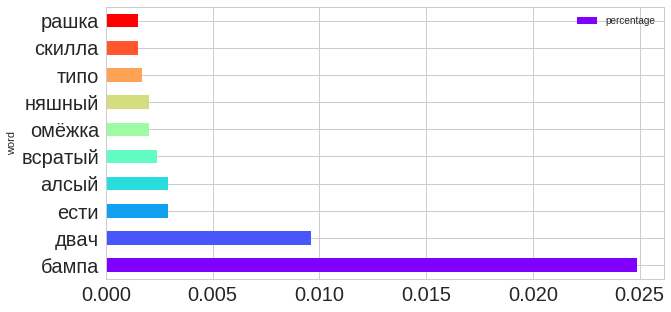

In [12]:
AMOUNT_OF_SHOWN_WORDS = 10

%matplotlib inline

rcParams['figure.figsize'] = 10, 5
params = {'xtick.labelsize': 20, 'ytick.labelsize': 20}
plt.rcParams.update(params)
seaborn.set_style('whitegrid')
df[:AMOUNT_OF_SHOWN_WORDS].plot.barh(x='word', y='percentage', color=cm.rainbow(np.linspace(0, 1, AMOUNT_OF_SHOWN_WORDS)))

Обучение Word2Vec-модели на наборе постов

In [13]:
word2vec_model = Word2Vec([word_tokenize(post.lower()) for post in posts], min_count=3, size=100, window=5,  workers=4) 

Визуализация части пространства Word2Vec-модели на примере семантически близких к заданному слову слов 

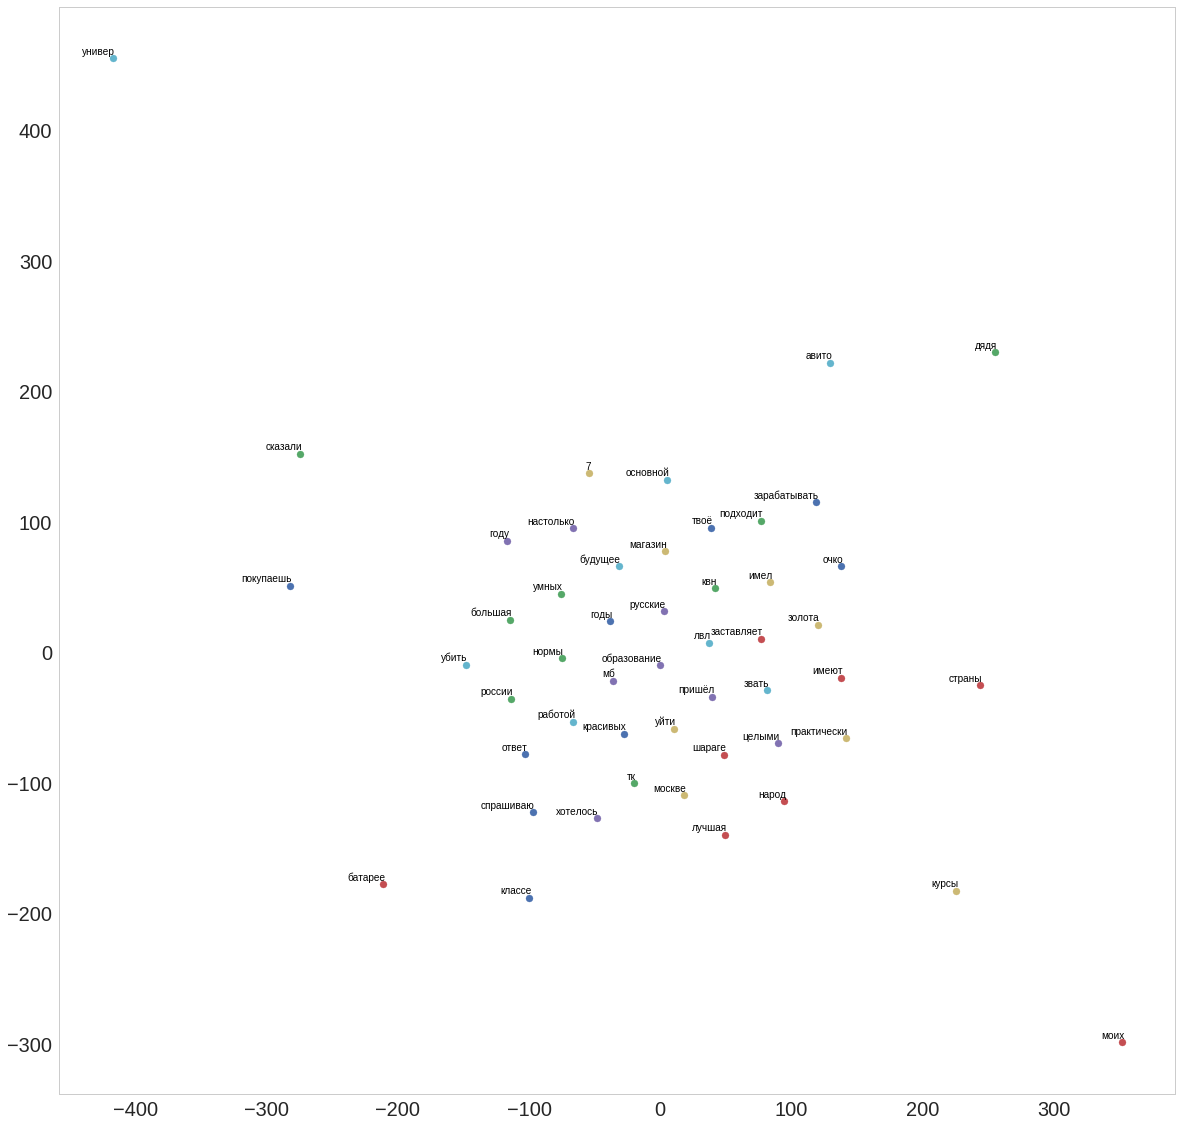

In [15]:
WORD = 'корзина'
TOPN=50

labels = []
tokens = []

for word in word2vec_model.most_similar(WORD, topn=TOPN):
    tokens.append(word2vec_model[word[0]])
    labels.append(word[0])
    
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(tokens)

x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(20, 20))
seaborn.set_style('whitegrid')
plt.grid(False)
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
                fontsize=10,
                color='black',
                xy=(x[i], y[i]),
                xytext=(2, 2),
                textcoords='offset points',
                ha='right',
                va='bottom')

Обучение TF-IDF-векторизатора на наборе постов

In [16]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(posts)
terms = vectorizer.get_feature_names()

Кластеризация TF-IDF-пространства с помощью K-Means

In [17]:
NUM_CLUSTERS = 13

kmeans_model = KMeans(n_clusters=NUM_CLUSTERS , init='k-means++', max_iter=100, n_init=1)
kmeans_model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=13, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Отображение заданного набора наиболее близких к центроиду слов для каждого кластера

In [18]:
NUM_WORDS = 5

centroid_terms = [[]]*NUM_CLUSTERS

order_centroids = kmeans_model.cluster_centers_.argsort()[:, ::-1]

for i in range(NUM_CLUSTERS):
    centroid_terms[i] = set()
    print('Кластер {}:'.format(i))
    for j in order_centroids[i, :NUM_WORDS]:
        print(terms[j])
        centroid_terms[i].add(terms[j])
    print()

Кластер 0:
ес
тишина
чо
хули
нравится

Кластер 1:
прямо
великую
стенки
навязывать
баха

Кластер 2:
удовольствие
нерекомендую
физическое
фапапсихологическое
очкуешь

Кластер 3:
манятред
азимова
рассказ
прочитал
создать

Кластер 4:
бамп
бампать
лютый
последний
сука

Кластер 5:
дать
одноклассницу
власть
отсосать
предложил

Кластер 6:
унижает
музыкальный
вкус
её
калтактике

Кластер 7:
то
лол
лет
тян
что

Кластер 8:
факт
реальной
возраст
какого
опыта

Кластер 9:
голова
дай
денег
пожалуйста
великая

Кластер 10:
тоскливо
вечерам
писать
молодость
звать

Кластер 11:
опоздал
漢字
калреквеститруют
камвхора
камаза

Кластер 12:
аптечном
сортировщик
складе
漢字
камвхорами



Визуализация центроидов кластеров

In [ ]:
def search_for_centroid_terms(term):
    for i, k in enumerate(centroid_terms):
        if term in k:
            return i,term
        
#RANGE = 1

colors = cm.rainbow(np.linspace(0, 1, NUM_CLUSTERS))

reduced_X = PCA(n_components=2).fit_transform(X.todense())
#tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=42)
#reduced_X = tsne_model.fit_transform(X.todense())

for i, _ in enumerate(reduced_X):
    if search_for_centroid_terms(terms[i]):
        cluster, term = search_for_centroid_terms(terms[i])
        plt.scatter(*reduced_X[i], color=colors[cluster])
        plt.annotate('{}: {}'.format(cluster, term), (reduced_X[i]))

plt.legend([mpatches.Rectangle((0,0),1,1,fc=colors[i]) for i in range(len(colors))],
           ['Кластер {}'.format(i) for i in range(NUM_CLUSTERS)],
           loc=4,
           fontsize=12)   
plt.plot()
#plt.xlim(-RANGE, RANGE)
#plt.ylim(-RANGE, RANGE)
plt.show()